- 2: herald
- 3: transmitted
- 4: reflected

In [1]:
from scipy.io import loadmat
from scipy.stats import norm 
from scipy.optimize import curve_fit
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from math import log10, floor

import matplotlib
import matplotlib.pyplot as plt

# plt.rc('font',**{'size':11, 'family':'serif','serif':['Computer Modern Roman']})
# plt.rc('text', usetex=False)
# plt.rc('mathtext', **{'fontset':'cm'})
# plt.rc('xtick', labelsize = 11)
# plt.rc('ytick', labelsize = 11)

In [2]:
def latex_figsize(wf=0.5, hf=(5.**0.5-1.0)/2.0, columnwidth=469.7550):
    # correct size in matplotlib
    fig_width_pt = columnwidth*wf 
    inches_per_pt = 1.0/72.27
    fig_width = fig_width_pt*inches_per_pt
    fig_height = fig_width*hf
    return [fig_width, fig_height]

In [3]:
def round_sig(x, sig=2):
    # round to significant digit
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [4]:
# interpolating functions
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, _ = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

def gauss_err(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    _, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return np.sqrt(np.diag(pcov))

In [5]:
def read_mat(filename):
    # read dataset
    dataset = loadmat('data/{}.mat'.format(filename))
    tt = dataset['data'][0][0][0][0]
    ch = dataset['data'][0][0][1][0]
    df = pd.DataFrame({'tt':tt, 'ch':ch})
    df.name = filename
    return df

In [6]:
def find_coincidence(df, window=15*1e3):

    diff_t = np.diff(df[df['ch']!=4]['tt'])*np.sign(np.diff(df[df['ch']!=4]['ch']))
    diff_r = np.diff(df[df['ch']!=3]['tt'])*np.sign(np.diff(df[df['ch']!=3]['ch']))
    
    print('Processing ' + df.name + ' ...')
               
    diff_t = diff_t[diff_t!=0]
    diff_r = diff_r[diff_r!=0]
    
    # filter on tens of ns
    diff_t = diff_t[(diff_t < 0) & (diff_t > - window)]
    diff_r = diff_r[(diff_r < 0) & (diff_r > - window)]

    print('Done!')

    return diff_t, diff_r

In [7]:
def projector_prob(df_t, df_r, plot=False):

    height_t, bins_t = np.histogram(df_t, bins=150, density=False)
    height_r, bins_r = np.histogram(df_r, bins=150, density=False)

    plt.scatter(bins_t[1:], height_t, alpha=0.8, label='SPD$_{2,3}$')
    plt.scatter(bins_r[1:], height_r, alpha=0.8, label='SPD$_{2,4}$')

    centers_t = (0.5*(bins_t[1:]+bins_t[:-1]))
    _, _, x0t, sigmat = gauss_fit(centers_t, height_t)
    
    centers_r = (0.5*(bins_r[1:]+bins_r[:-1]))
    _, _, x0r, sigmar = gauss_fit(centers_r, height_r)

    if plot:
        plt.plot(bins_t[1:], gauss(bins_t[1:], *gauss_fit(bins_t[1:], height_t)), label='fit trans.')
        plt.plot(bins_r[1:], gauss(bins_r[1:], *gauss_fit(bins_r[1:], height_r)), label='fit ref.')
        plt.show()

    df_t_3s = df_t[(x0t-3*np.abs(sigmat) < df_t) & (x0t+3*np.abs(sigmat) > df_t)]
    df_r_3s = df_r[(x0r-3*np.abs(sigmar) < df_r) & (x0r+3*np.abs(sigmar) > df_r)]
    
    tr = len(df_t_3s) + len(df_r_3s)
    
    t = len(df_t_3s)
    prob_t = t / tr
    err_t  = prob_t*np.sqrt(1/t + 1/tr)
    
    r = len(df_r_3s)
    prob_r = r / tr
    err_r  = prob_t*np.sqrt(1/r + 1/tr)
    
    return {'T': prob_t, 'R':prob_r, 'sigma_T':err_t, 'sigma_R':err_r, 'N':tr}

Processing d_state_measured_on_da_basis ...
Done!


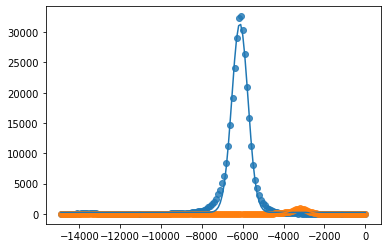

Processing d_state_measured_on_hv_basis ...
Done!


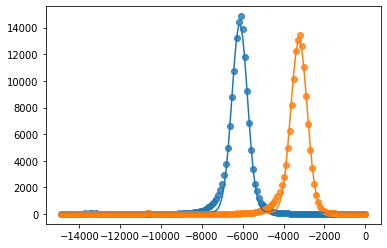

Processing mixed_state_measured_on_da_basis ...
Done!


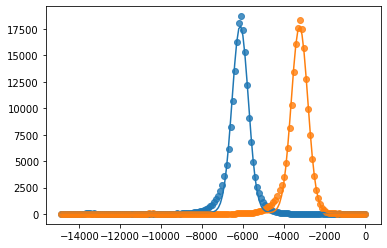

Processing mixed_state_measured_on_hv_basis ...
Done!


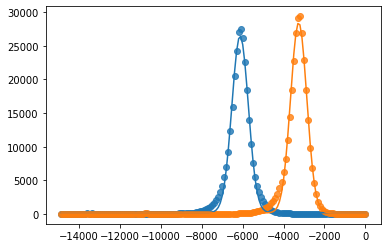

Processing l_state_measured_on_da_basis ...
Done!


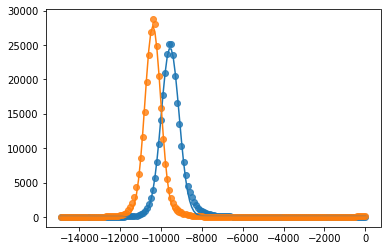

Processing l_state_measured_on_hv_basis ...
Done!


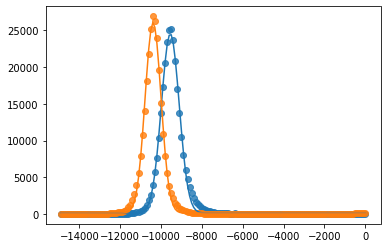

Processing l_state_measured_on_lr_basis ...
Done!


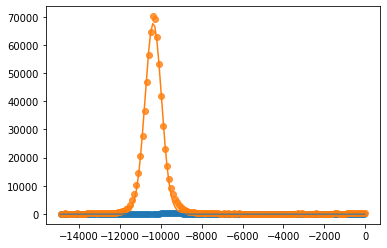

In [8]:
prob_dict= {}

filenames = ['d_state_measured_on_da_basis',
             'd_state_measured_on_hv_basis',
             'mixed_state_measured_on_da_basis',
             'mixed_state_measured_on_hv_basis',
             'l_state_measured_on_da_basis',
             'l_state_measured_on_hv_basis',
             'l_state_measured_on_lr_basis']


for filename in filenames:
    df = read_mat(filename)
    df_t, df_r = find_coincidence(df)
    prob_dict[filename] = projector_prob(df_t, df_r, plot=True)

In [9]:
prob_dict

{'d_state_measured_on_da_basis': {'T': 0.972236732056535,
  'R': 0.027763267943464988,
  'sigma_T': 0.0024061625305912505,
  'sigma_R': 0.010278806828167267,
  'N': 331193},
 'd_state_measured_on_hv_basis': {'T': 0.5158855144912879,
  'R': 0.4841144855087121,
  'sigma_T': 0.0016806717425661675,
  'sigma_R': 0.0017166668737811012,
  'N': 276856},
 'mixed_state_measured_on_da_basis': {'T': 0.5003263743078145,
  'R': 0.4996736256921855,
  'sigma_T': 0.0014288509544500034,
  'sigma_R': 0.0014294728768757487,
  'N': 367676},
 'mixed_state_measured_on_hv_basis': {'T': 0.4888467048081064,
  'R': 0.5111532951918937,
  'sigma_T': 0.0011310453333605176,
  'sigma_R': 0.0011143459654658263,
  'N': 568935},
 'l_state_measured_on_da_basis': {'T': 0.4996717875068907,
  'R': 0.5003282124931093,
  'sigma_T': 0.001165678514636767,
  'sigma_R': 0.0011651685057980073,
  'N': 551472},
 'l_state_measured_on_hv_basis': {'T': 0.513125194884731,
  'R': 0.4868748051152691,
  'sigma_T': 0.001204036808014953,
  '

In [10]:
def quadrature(a, b):
    return np.sqrt(a**2 + b**2)

def min_entropy(dicto):
    if dicto.get('T') > dicto.get('R'):
        p_guess = dicto.get('T')
        err_p   = dicto.get('sigma_T')
    else:
        p_guess = dicto.get('R')
        err_p   = dicto.get('sigma_R')
    return -np.log2(p_guess), err_p / (p_guess*np.log(2))

def entropic(dicto): # covariance?
    pt = dicto.get('T')
    pr = dicto.get('R')
    fact = 1/((np.sqrt(pt)+np.sqrt(pr))*np.log(2))
    err = fact*np.sqrt(dicto.get('sigma_T')**2/pt + dicto.get('sigma_R')**2/pr)
    return 1 - 2*np.log2(np.sqrt(pt)+np.sqrt(pr)), err

def fiorentina(S1, sigma_S1, S2=0, sigma_S2=0):
    rho12 = complex(S1,-S2)
    stefano = (1.+np.sqrt(1. - np.abs(rho12)**2))/2.
    fact1 = 0.5*(1-(S1**2+S2**2))**(-.5)
    fact2 = (np.log(2)*stefano)**(-1)
    err = fact1*fact2*np.sqrt((S1*sigma_S1)**2 + (S2*sigma_S2)**2)
    return - np.log2(stefano), err

In [11]:
# 3
H_trusted_pure, sigma_H_trusted_pure = min_entropy(prob_dict['d_state_measured_on_hv_basis'])
H_trusted_mixed, sigma_H_trusted_mixed = min_entropy(prob_dict['mixed_state_measured_on_hv_basis'])

print('Trusted scenario, pure state: ', round_sig(H_trusted_pure), '+-', round_sig(sigma_H_trusted_pure))
print('Trusted scenario, mixed state: ', round_sig(H_trusted_mixed), '+-', round_sig(sigma_H_trusted_mixed))

Trusted scenario, pure state:  0.95 +- 0.0047
Trusted scenario, mixed state:  0.97 +- 0.0031


In [12]:
# 4
qc_D, err_qc_D = entropic(prob_dict['d_state_measured_on_da_basis'])
qc_mixed, err_qc_mixed = entropic(prob_dict['mixed_state_measured_on_da_basis'])

print('Q. cond. min-entropy (entropic uncertainty principle), pure state D: ', round_sig(qc_D), '+-', round_sig(err_qc_D))
print('Q. cond. min-entropy (entropic uncertainty principle), mixed state: ', round_sig(qc_mixed), '+-', round_sig(err_qc_mixed))

Q. cond. min-entropy (entropic uncertainty principle), pure state D:  0.59 +- 0.077
Q. cond. min-entropy (entropic uncertainty principle), mixed state:  1.5e-07 +- 0.0029


In [13]:
# 5
S3_pure_d = prob_dict['d_state_measured_on_hv_basis']['T'] - prob_dict['d_state_measured_on_hv_basis']['R']
S1_pure_d = prob_dict['d_state_measured_on_da_basis']['T'] - prob_dict['d_state_measured_on_da_basis']['R']
S3_mixed = prob_dict['mixed_state_measured_on_hv_basis']['T'] - prob_dict['mixed_state_measured_on_hv_basis']['R']
S1_mixed = prob_dict['mixed_state_measured_on_da_basis']['T'] - prob_dict['mixed_state_measured_on_da_basis']['R']

# errors
err_S1_pure_d = quadrature(prob_dict['d_state_measured_on_da_basis']['sigma_T'], prob_dict['d_state_measured_on_da_basis']['sigma_R'])
err_S1_mixed = quadrature(prob_dict['mixed_state_measured_on_da_basis']['sigma_T'], prob_dict['mixed_state_measured_on_da_basis']['sigma_R'])

In [14]:
H_pure_D, err_H_pure_D = fiorentina(S1_pure_d, err_S1_pure_d)
H_mixed, err_H_mixed = fiorentina(S1_mixed, err_S1_mixed)

print('Q. cond. min-entropy (Q. tomography, S2=0), pure state D: ', round_sig(H_pure_D), '+-', round_sig(err_H_pure_D))
print('Q. cond. min-entropy (Q. tomography, S2=0), mixed state: ', round_sig(H_mixed), '+-', round_sig(err_H_mixed))

Q. cond. min-entropy (Q. tomography, S2=0), pure state D:  0.59 +- 0.033
Q. cond. min-entropy (Q. tomography, S2=0), mixed state:  1.5e-07 +- 9.5e-07


In [15]:
# 6
S1_pure_l = prob_dict['l_state_measured_on_da_basis']['T'] - prob_dict['l_state_measured_on_da_basis']['R']
S2_pure_l = prob_dict['l_state_measured_on_lr_basis']['T'] - prob_dict['l_state_measured_on_lr_basis']['R']

# errors
err_S1_pure_l = quadrature(prob_dict['l_state_measured_on_da_basis']['sigma_T'], prob_dict['l_state_measured_on_da_basis']['sigma_R'])
err_S2_pure_l = quadrature(prob_dict['l_state_measured_on_lr_basis']['sigma_T'], prob_dict['l_state_measured_on_lr_basis']['sigma_R'])

In [16]:
H_pure_L, err_H_pure_L = entropic(prob_dict['l_state_measured_on_da_basis'])
print('Q. cond. min-entropy (entropic uncert. princ.), pure state L: ', round_sig(H_pure_L), '+-', round_sig(err_H_pure_L))

Q. cond. min-entropy (entropic uncert. princ.), pure state L:  1.6e-07 +- 0.0024


In [17]:
H_pure_L, err_H_pure_L = fiorentina(S1_pure_l, err_S1_pure_l, S2_pure_l, err_S2_pure_l)
print('Q. cond. min-entropy (full Q. tomography), pure state L: ', H_pure_L, '+-', round_sig(err_H_pure_L))

H_pure_L, err_H_pure_L = entropic(prob_dict['l_state_measured_on_lr_basis'])
print('Q. cond. min-entropy (entropic uncert. princ.), pure state L: ', H_pure_L, '+-', round_sig(err_H_pure_L))

Q. cond. min-entropy (full Q. tomography), pure state L:  0.8029521575072017 +- 0.00075
Q. cond. min-entropy (entropic uncert. princ.), pure state L:  0.8029503048219028 +- 0.0016


In [18]:
# 7
def eps_bound(H_mins,H_min_names,Ns):
    for i,H_min in enumerate(H_mins):
        N = Ns[i]
        #a =  (H_min + 2. - ell_Z)*0.5
        ell_Z = np.linspace(1,N,1000)
        x = ell_Z-H_min*N
        eps = 0.5*np.sqrt(2**(x))
        plt.plot(x, eps, label=H_min_names[i])
    #plt.fill_between(ell_Z, eps, max(eps), alpha=0.3, color='g')
    #plt.fill_between(ell_Z, min(eps), eps, alpha=0.3, color='r')
    plt.xlabel('L-NH')
    plt.ylabel(r'$\Delta$')
    plt.title('LHL security vs block length')
    plt.yscale('log')
    #plt.ylim(0,0.00000001)
    plt.grid()
    plt.legend()
    plt.show()

In [19]:
prob_dict.keys()

dict_keys(['d_state_measured_on_da_basis', 'd_state_measured_on_hv_basis', 'mixed_state_measured_on_da_basis', 'mixed_state_measured_on_hv_basis', 'l_state_measured_on_da_basis', 'l_state_measured_on_hv_basis', 'l_state_measured_on_lr_basis'])

<ipython-input-18-cf80b8938071>:8: RuntimeWarning: overflow encountered in power
  eps = 0.5*np.sqrt(2**(x))
<ipython-input-18-cf80b8938071>:8: RuntimeWarning: overflow encountered in power
  eps = 0.5*np.sqrt(2**(x))
<ipython-input-18-cf80b8938071>:8: RuntimeWarning: overflow encountered in power
  eps = 0.5*np.sqrt(2**(x))
<ipython-input-18-cf80b8938071>:8: RuntimeWarning: overflow encountered in power
  eps = 0.5*np.sqrt(2**(x))
<ipython-input-18-cf80b8938071>:8: RuntimeWarning: overflow encountered in power
  eps = 0.5*np.sqrt(2**(x))


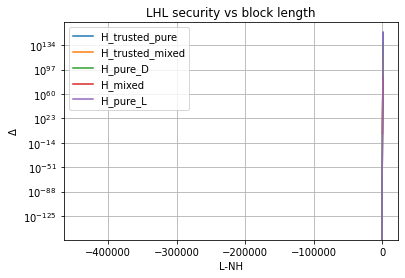

In [20]:
H_mins = [H_trusted_pure, H_trusted_mixed, H_pure_D, H_mixed, H_pure_L]
H_mins_names = ['H_trusted_pure', 'H_trusted_mixed', 'H_pure_D', 'H_mixed', 'H_pure_L']
dict_keys = ['d_state_measured_on_da_basis', 'd_state_measured_on_hv_basis', 'mixed_state_measured_on_da_basis', 'mixed_state_measured_on_hv_basis', 'l_state_measured_on_da_basis', 'l_state_measured_on_hv_basis', 'l_state_measured_on_lr_basis']
N_s = [prob_dict[dict_keys[i]]['N'] for i in range(len(dict_keys))]
eps_bound(H_mins,H_mins_names,N_s)

In blocks

In [21]:
# 7
def eps_bound(H_min, N, M):
    for m in M:
        block_size = N/m
        ell_Z = np.linspace(1,H_min*block_size,1000)
        eps = 0.5*np.sqrt(2**(ell_Z-H_min*block_size))
        plt.plot(ell_Z*m, eps*m, label=m)
        plt.axvline(x=H_min*N)
    #plt.fill_between(ell_Z, eps, max(eps), alpha=0.3, color='g')
    #plt.fill_between(ell_Z, min(eps), eps, alpha=0.3, color='r')
    plt.xlabel('L*m')
    plt.ylabel(r'$\Delta$*m')
    plt.title('LHL security vs block length')
    plt.yscale('log')
    plt.ylim([1e-20,1])
    plt.xlim([5.5e5,5.68e5])
    plt.grid()
    plt.legend()
    plt.show()

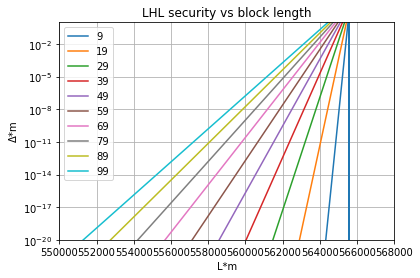

In [22]:
eps_bound(H_pure_L, prob_dict['l_state_measured_on_lr_basis']['N'], np.arange(9,100,10))

In [23]:
# come ha detto marco
def delta(H_mins,H_min_names):
    ell_Z = np.linspace(1,30000,10000)
    for i,H_min in enumerate(H_mins):
        eps = 0.5*np.sqrt(2**((ell_Z-H_min*30000)))
        plt.plot(ell_Z, eps, label=H_min_names[i])
    #plt.fill_between(ell_Z, eps, max(eps), alpha=0.3, color='g')
    #plt.fill_between(ell_Z, min(eps), eps, alpha=0.3, color='r')
    plt.xlabel('L')
    plt.ylabel(r'$\Delta$')
    plt.title('LHL security vs block length')
    plt.yscale('log')
    plt.ylim(0E-10)

    plt.grid()
    plt.legend()
    plt.show()

<ipython-input-23-74cc1cec049a>:5: RuntimeWarning: overflow encountered in power
  eps = 0.5*np.sqrt(2**((ell_Z-H_min*30000)))
<ipython-input-23-74cc1cec049a>:5: RuntimeWarning: overflow encountered in power
  eps = 0.5*np.sqrt(2**((ell_Z-H_min*30000)))
<ipython-input-23-74cc1cec049a>:5: RuntimeWarning: overflow encountered in power
  eps = 0.5*np.sqrt(2**((ell_Z-H_min*30000)))
<ipython-input-23-74cc1cec049a>:5: RuntimeWarning: overflow encountered in power
  eps = 0.5*np.sqrt(2**((ell_Z-H_min*30000)))
<ipython-input-23-74cc1cec049a>:13: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0E-10)


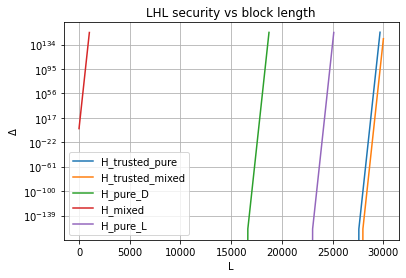

In [24]:
H_mins = [H_trusted_pure, H_trusted_mixed, H_pure_D, H_mixed, H_pure_L]
H_mins_names = ['H_trusted_pure', 'H_trusted_mixed', 'H_pure_D', 'H_mixed', 'H_pure_L']
delta(H_mins,H_mins_names)

14-12 alla sera

In [25]:
ell_Z = np.linspace(0.9*N-10000,0.9*N,1000)
ell_Z

NameError: name 'N' is not defined

In [26]:
def eps_bound(H_min, N):
    ell_Z = np.linspace(H_min*N*0.99,H_min*N,10)
    print('bit massimi estraibili', N*H_min)
    eps = 0.5*np.sqrt(2**(ell_Z-H_min*N))
    print(ell_Z)
    plt.plot(ell_Z, eps)
    plt.axvline(x=H_min*N, label ='bit massimi estraibili', lw=4, ls='dotted', color='red')
    plt.xlabel('L')
    plt.ylabel(r'$\Delta$')
    plt.title('LHL security vs block length')
    plt.grid()
    plt.legend()
    plt.ylim(1e-100,0.1)
    plt.xlim(442000,445000)
    plt.show()

In [27]:
N=prob_dict['l_state_measured_on_da_basis']['N']

In [28]:
block_sizes = [floor(N/2**i) for i in range(10)]

bit massimi estraibili 442804.61050074437
[438376.56439574 438868.56951852 439360.57464129 439852.57976407
 440344.58488685 440836.59000963 441328.59513241 441820.60025519
 442312.60537797 442804.61050074]


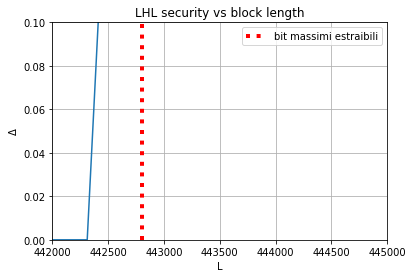

In [29]:

H_mins_names = ['H_pure_L']
eps_bound(H_pure_L,prob_dict['l_state_measured_on_da_basis']['N'])

430039.49585260457


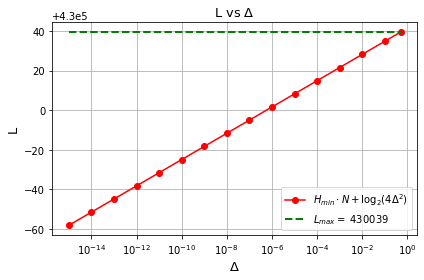

In [76]:
N_pure_L=prob_dict['l_state_measured_on_hv_basis']['N']
H_pure_L, _ = fiorentina(S1_pure_l, err_S1_pure_l, S2_pure_l, err_S2_pure_l)
delta = np.array([1e-15,1e-14,1e-13,1e-12,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,0.5])
limit = np.full(len(delta),N_pure_L*H_pure_L)
plt.plot(delta, H_pure_L*N_pure_L+np.log2(4*delta*delta), marker='o', label=r'$H_{min}\cdot N+\log_2({4\Delta^2})$', color = 'red')
#plt.plot(delta, H_pure_D*N_pure_D+np.log2(4*delta*delta))

plt.xlabel(r'$\Delta$', size=13)
plt.xscale('log')
plt.ylabel('L', size=13)
plt.plot(delta,limit, color='green', lw=2, ls='--', label='$L_{max} = $ %3.f' % (H_pure_L*N_pure_L))
#plt.axhline(y=N_pure_D*H_pure_D)
print(N_pure_L*H_pure_L)
plt.legend()
plt.title('L vs $\Delta$', size=13)
plt.grid()
plt.tight_layout()
#plt.text(10e-16, 442795, r'$\ell_{max}=H_{min}\cdot N=442805$ bits', size=13, color='purple')
#plt.savefig('leonardo.pdf')
plt.show()


In [55]:
delta

array([1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08,
       1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])

In [32]:
def eps_bound(H_min, N, M):
    for m in M:
        block_size = N/m
        ell_Z = np.linspace(1,H_min*block_size,1000)
        eps = 0.5*np.sqrt(2**(ell_Z-H_min*block_size))
        plt.plot(ell_Z*m, eps*m, label=m)
        plt.axvline(x=H_min*N)
    plt.xlabel('L*m')
    plt.ylabel(r'$\Delta$*m')
    plt.title('LHL security vs block length')
    plt.yscale('log')
    plt.ylim([1e-20,1])
    plt.xlim([5.5e5,5.68e5])
    plt.grid()
    plt.legend()
    plt.show()

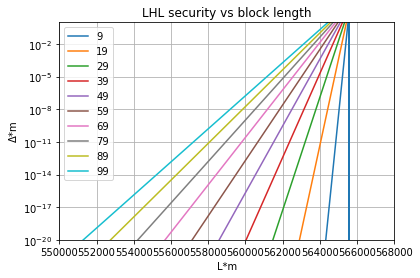

In [33]:
eps_bound(H_pure_L, prob_dict['l_state_measured_on_lr_basis']['N'], np.arange(9,100,10))

In [82]:
colors = ['paleturquoise','cyan','deepskyblue','dodgerblue','royalblue']
colors = colors[::-1]
def eps_bound(H_min, N):
    M = [1, 10, 128, 512, 1024]
    #M = [2**i for i in range(15)]
    i = 0
    for m in M:
        block_size = N/m

        ell_Z = np.linspace(1,H_min*block_size,1000)
        eps = 0.5*np.sqrt(2**(ell_Z-H_min*block_size))
        acca = str(int(H_min*block_size))+' (m='+str(m)+')'
        plt.plot(N*H_min-ell_Z*m, eps*m, label=acca, lw=3, color=colors[i])
        i += 1


    plt.xlabel('$L_{removed}$', size=13)
    #plt.xlabel('$H_{min}\cdot N-L\cdot m$', size=13)
    plt.ylabel(r'$\Delta_{tot}}$', size=13)
    plt.title('$\Delta$ vs $L_{removed}$ for different block size hashing')
    plt.yscale('log')
    plt.ylim([1e-20,1])
    plt.xlim([-10000,1.6e5])
    legend = plt.legend(loc=1, fancybox=True)
    legend.set_title("Block size $N/m$") 
    plt.grid()
    plt.tight_layout()
    #plt.legend()
    plt.show()
    #plt.savefig('renzo.pdf')


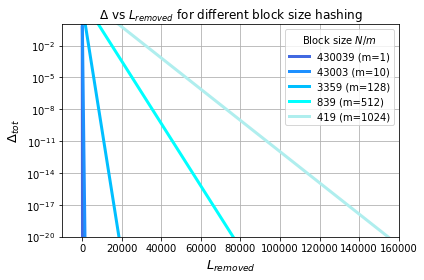

In [83]:
eps_bound(H_pure_L, prob_dict['l_state_measured_on_hv_basis']['N'])

In [68]:
qc_mixed, _ = entropic(prob_dict['d_state_measured_on_hv_basis'])

In [69]:
prob_dict.keys()

dict_keys(['d_state_measured_on_da_basis', 'd_state_measured_on_hv_basis', 'mixed_state_measured_on_da_basis', 'mixed_state_measured_on_hv_basis', 'l_state_measured_on_da_basis', 'l_state_measured_on_hv_basis', 'l_state_measured_on_lr_basis'])

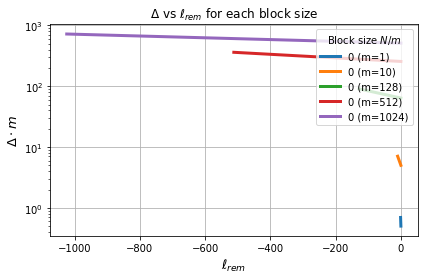

In [70]:
eps_bound(qc_mixed, prob_dict['mixed_state_measured_on_da_basis']['N'])

In [71]:
qc_mixed

1.5367617267614264e-07